<a href="https://colab.research.google.com/github/Siddharth-Singh-2004/CU-BEMS_Forecasting/blob/main/CU_BEMS_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
old_df=pd.read_csv('/content/drive/MyDrive/2018Floor1.csv')

In [87]:
data = {
    "Date": [],
    "z1_Light": []
}

In [88]:
for index, row in old_df.iterrows():
  if index%120 == 0:
    data["Date"].append(row["Date"])
    data["z1_Light"].append(row["z1_Light(kW)"])

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df['Date']=pd.to_datetime(df['Date'])

In [91]:
df.head()

,Date,z1_Light
0,2018-07-01 00:00:00,12.94
1,2018-07-01 02:00:00,13.12
2,2018-07-01 04:00:00,12.91
3,2018-07-01 06:00:00,12.77
4,2018-07-01 08:00:00,0.01


In [92]:
df.tail()

,Date,z1_Light
2203,2018-12-31 14:00:00,0.02
2204,2018-12-31 16:00:00,0.02
2205,2018-12-31 18:00:00,0.00
2206,2018-12-31 20:00:00,0.01
2207,2018-12-31 22:00:00,0.01


In [93]:
z1_Light = pd.Series(df['z1_Light'])

In [94]:
z1_Light.dropna(inplace=True)

In [95]:
z1_Light = z1_Light.to_numpy()

In [96]:
z1_Light[:10]

array([1.294e+01, 1.312e+01, 1.291e+01, 1.277e+01, 1.000e-02, 1.000e-02,
       1.000e-02, 0.000e+00, 0.000e+00, 1.308e+01])

In [97]:
max = z1_Light.max()
min = z1_Light.min()

In [98]:
# Normalization
normalized_z1_Light = (z1_Light - min)/(max - min)

In [99]:
normalized_z1_Light[:10]

array([2.65272653e-01, 2.68962690e-01, 2.64657647e-01, 2.61787618e-01,
       2.05002050e-04, 2.05002050e-04, 2.05002050e-04, 0.00000000e+00,
       0.00000000e+00, 2.68142681e-01])

In [100]:
len(normalized_z1_Light)

2197

In [101]:
# Custom Dataset
class TimeSeriesDataset(Dataset):

  def __init__(self, data, sequence_length):
    self.data = data
    self.sequence_length = sequence_length

  def __len__(self):
    return len(self.data) - self.sequence_length

  def __getitem__(self, idx):
    x = self.data[idx:idx+self.sequence_length]
    y = self.data[idx+self.sequence_length]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



In [102]:
train_size = int(len(normalized_z1_Light) * 0.8)
test_size = len(normalized_z1_Light) - train_size
number_of_hours_in_a_day = 12

dataset = TimeSeriesDataset(normalized_z1_Light[:train_size], sequence_length=number_of_hours_in_a_day)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Dataloader output
for batch_idx, (x, y) in enumerate(dataloader):
  print(f"Batch {batch_idx+1}:")
  print(f"x: {x}")
  print(f"y: {y}")


Batch 1:
x: tensor([[2.6876e-01, 0.0000e+00, 2.0500e-04, 4.1000e-04, 4.1000e-04, 2.0500e-04,
         2.0500e-04, 0.0000e+00, 2.6548e-01, 2.6507e-01, 2.6732e-01, 2.6773e-01],
        [0.0000e+00, 2.6691e-01, 2.7675e-01, 2.2878e-01, 2.7142e-01, 2.7511e-01,
         2.7532e-01, 2.6937e-01, 4.1000e-04, 2.0500e-04, 4.1000e-04, 2.0500e-04],
        [2.0500e-04, 4.1000e-04, 2.0500e-04, 4.1000e-04, 4.1000e-04, 2.0500e-04,
         0.0000e+00, 0.0000e+00, 2.0500e-04, 6.1501e-04, 2.6486e-01, 2.7019e-01],
        [9.2128e-01, 9.1390e-01, 9.1533e-01, 9.1410e-01, 2.0500e-04, 2.0500e-04,
         2.0500e-04, 2.0500e-04, 2.0500e-04, 2.0500e-04, 2.6507e-01, 2.6958e-01],
        [2.6896e-01, 2.6876e-01, 2.7040e-01, 2.6568e-01, 2.6753e-01, 2.7040e-01,
         0.0000e+00, 4.1000e-04, 4.1000e-04, 4.1000e-04, 4.1000e-04, 2.0500e-04],
        [2.6732e-01, 2.7060e-01, 2.6589e-01, 2.6527e-01, 2.6937e-01, 2.6917e-01,
         2.0500e-04, 0.0000e+00, 0.0000e+00, 2.0500e-04, 2.0500e-04, 2.0500e-04],
        [2

In [104]:
# Transformer model
class TimeSeriesTransformer(nn.Module):

  def __init__(self, input_size, d_model, n_heads, num_layers):
    super(TimeSeriesTransformer, self).__init__()
    self.embedding = nn.Linear(input_size, d_model)
    self.positional_embedding = nn.Parameter(torch.zeros(40, d_model))
    self.transformer = nn.Transformer(d_model, n_heads, num_layers)
    self.fc_out = nn.Linear(d_model, 1)

  def forward(self, src):
    src = src.unsqueeze(-1)
    src = self.embedding(src)
    src = src + self.positional_embedding[:src.size(1), :]
    src = src.permute(1, 0, 2)
    transformer_output = self.transformer(src, src)
    transformer_output = transformer_output.permute(1, 0, 2)
    output = self.fc_out(transformer_output)
    return output[:, -1, :]



In [105]:
def compute_r2(y_true, y_pred):
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2_score = 1 - (ss_res / ss_tot)
    return r2_score

In [106]:
# Initializations
input_size = 1
d_model = 64
n_heads = 16
num_layers = 2
sequence_length = 12
model = TimeSeriesTransformer(input_size, d_model, n_heads, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Training loop
epochs = 100
for epoch in range(epochs):
  epoch_loss = 0.0
  epoch_r2 = 0.0
  for x, y in dataloader:
    optimizer.zero_grad()
    y = y.unsqueeze(-1)
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

    r2 = compute_r2(y, output)
    epoch_r2 += r2

  epoch_loss /= len(dataloader)
  epoch_r2 /= len(dataloader)

  print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, R²: {epoch_r2:.4f}')


Epoch 1, Loss: 0.2821, R²: -7.2629
Epoch 2, Loss: 0.0432, R²: -0.2687
Epoch 3, Loss: 0.0405, R²: -0.2124
Epoch 4, Loss: 0.0413, R²: -0.2218
Epoch 5, Loss: 0.0387, R²: -0.1334
Epoch 6, Loss: 0.0381, R²: -0.1187
Epoch 7, Loss: 0.0382, R²: -0.1489
Epoch 8, Loss: 0.0380, R²: -0.1009
Epoch 9, Loss: 0.0369, R²: -0.0692
Epoch 10, Loss: 0.0355, R²: -0.0755
Epoch 11, Loss: 0.0341, R²: -0.0086
Epoch 12, Loss: 0.0333, R²: 0.0241
Epoch 13, Loss: 0.0299, R²: 0.1091
Epoch 14, Loss: 0.0284, R²: 0.1627
Epoch 15, Loss: 0.0273, R²: 0.2130
Epoch 16, Loss: 0.0230, R²: 0.3069
Epoch 17, Loss: 0.0204, R²: 0.3940
Epoch 18, Loss: 0.0202, R²: 0.3844
Epoch 19, Loss: 0.0198, R²: 0.4446
Epoch 20, Loss: 0.0190, R²: 0.4411
Epoch 21, Loss: 0.0197, R²: 0.4308
Epoch 22, Loss: 0.0189, R²: 0.4365
Epoch 23, Loss: 0.0184, R²: 0.4684
Epoch 24, Loss: 0.0187, R²: 0.4692
Epoch 25, Loss: 0.0182, R²: 0.4871
Epoch 26, Loss: 0.0193, R²: 0.3973
Epoch 27, Loss: 0.0187, R²: 0.4272
Epoch 28, Loss: 0.0180, R²: 0.4816
Epoch 29, Loss: 0.

In [ ]:
# Forecasting
model.eval()
with torch.no_grad():
  last_sequence = torch.tensor(normalized_z1_Light[-sequence_length:], dtype=torch.float32).unsqueeze(0)
  forecast_length = test_size
  forecasts = []

  for _ in range(forecast_length):
    normalized_forecast = model(last_sequence)
    forecast = normalized_forecast.item() * (max - min) + min
    print(f'Forecast: {forecast}')
    forecasts.append(forecast)

    new_forecast = torch.tensor([normalized_forecast.item()], dtype=torch.float32).unsqueeze(0)
    last_sequence = torch.cat((last_sequence[:, 1:], new_forecast), dim=1)

  print(f'List of forecasts: {forecasts}')

Forecast: 2.5020652994513513
Forecast: 3.8821283577382566
Forecast: 5.514918034225702
Forecast: 6.064179156124592
Forecast: 6.981141652464867
Forecast: 8.278768313527108
Forecast: 9.143024112582207
Forecast: 5.434333723783493
Forecast: 1.2778976300731302
Forecast: 1.1521312700584532
Forecast: 1.1516575269028544
Forecast: 1.1620789677277208
Forecast: 1.3949897838011385
Forecast: 2.7776994980871677
Forecast: 3.086791557222605
Forecast: 4.008356649130583
Forecast: 5.351497906744481
Forecast: 7.7275580665469175
Forecast: 10.106490123867989
Forecast: 10.642723036408425
Forecast: 10.469430079758167
Forecast: 10.220535929203034
Forecast: 4.0125387454032895
Forecast: 1.1953640128299594
Forecast: 1.1358531862869858
Forecast: 1.1435386558994651
Forecast: 1.2044672592356802
Forecast: 2.8354100279510024
Forecast: 10.183702807724476
Forecast: 10.765451407134533
Forecast: 11.060787287950516
Forecast: 11.096647118926048
Forecast: 11.17944659203291
Forecast: 11.135434090197087
Forecast: 1.631095685809

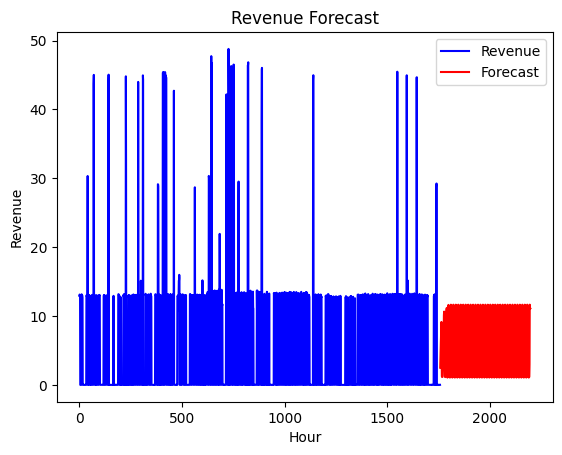

In [ ]:
new_z1_Light = np.concatenate([z1_Light[:train_size], forecasts])
x = np.arange(1, len(new_z1_Light) + 1)

split_point = len(new_z1_Light) - len(forecasts)

plt.plot(x[:split_point], new_z1_Light[:split_point], label='Revenue', color='blue')

plt.plot(x[split_point:], new_z1_Light[split_point:], label='Forecast', color='red')

plt.xlabel('Hour')
plt.ylabel('Revenue')
plt.title('Revenue Forecast')

plt.legend()

plt.show()

In [ ]:
mse = np.mean((z1_Light[train_size:] - forecasts) ** 2)
print(f'Mean Squared Error (MSE) per sample: {mse/test_size}')

Mean Squared Error (MSE) per sample: 0.1056492129502175
